In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  0


In [2]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input,  Activation
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, optimizers, layers
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [4]:
import pandas as pd
train_csv = 'C:/Users/Lenovo/Desktop/GP Code/train.csv'
train_df = pd.read_csv(train_csv)


In [5]:
train_df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:

train_df.shape

(76746, 3)

In [7]:
train_df.describe()

,id,label
count,76746.000000,76746.000000
mean,38373.500000,0.399812
std,22154.806217,0.489863
min,1.000000,0.000000
25%,19187.250000,0.000000
50%,38373.500000,0.000000
75%,57559.750000,1.000000
max,76746.000000,1.000000


In [8]:
# Getting the info about the train set
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76746 entries, 0 to 76745
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      76746 non-null  int64 
 1   label   76746 non-null  int64 
 2   tweet   76746 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [9]:
train_df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [10]:
import nltk  

nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import re                                  # library for regular expression operations
import string                              # for string operations
import emoji
from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import regexp_tokenize   # module for tokenizing strings
from nltk.tokenize import TreebankWordTokenizer
words = set(nltk.corpus.words.words())

In [12]:
def cleaner(tweet):
    tweet = tweet.encode("ascii", "ignore")
    tweet = tweet.decode()
    tweet = tweet.lower().split()
    tweet = " ".join(tweet)
    tweet = re.sub('\[.*?\]', '', tweet)
    tweet = re.sub('<.*?>+', '', tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = re.sub('\w*\d\w*', '', tweet)
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet)
    tweet = re.sub(' +', ' ', tweet) #Remove multiple space
    return tweet


In [13]:
train_df['tweet'].head(20)# before cleaning

0      @user when a father is dysfunctional and is s...
1     @user @user thanks for #lyft credit i can't us...
2                                   bihday your majesty
3     #model   i love u take with u all the time in ...
4                factsguide: society now    #motivation
5     [2/2] huge fan fare and big talking before the...
6      @user camping tomorrow @user @user @user @use...
7     the next school year is the year for exams.ð...
8     we won!!! love the land!!! #allin #cavs #champ...
9      @user @user welcome here !  i'm   it's so #gr...
10     â #ireland consumer price index (mom) climb...
11    we are so selfish. #orlando #standwithorlando ...
12    i get to see my daddy today!!   #80days #getti...
13    @user #cnn calls #michigan middle school 'buil...
14    no comment!  in #australia   #opkillingbay #se...
15    ouch...junior is angryð#got7 #junior #yugyo...
16    i am thankful for having a paner. #thankful #p...
17                               retweet if you 

In [14]:
train_df['tweet'] = train_df['tweet'].apply(lambda x: cleaner(x))

In [15]:
import numpy as np
train_df['tweet'].replace('', np.nan, inplace=True)

In [16]:
train_df.dropna(subset=['tweet'], inplace=True)

In [17]:
train_df.shape

(76689, 3)

In [18]:
train_df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [19]:
train_df['tweet'].head(20)#after cleaning

0      when a father is dysfunctional and is so self...
1      thanks for lyft credit i cant use cause they ...
2                                   bihday your majesty
3         model i love u take with u all the time in ur
4                     factsguide society now motivation
5      huge fan fare and big talking before they lea...
6                                camping tomorrow danny
7     the next school year is the year for exams can...
8     we won love the land allin cavs champions clev...
9                               welcome here im its so 
10    ireland consumer price index mom climbed from ...
11    we are so selfish orlando standwithorlando pul...
12               i get to see my daddy today gettingfed
13     cnn calls michigan middle school build the wa...
14    no comment in australia opkillingbay seashephe...
15               ouchjunior is angry junior yugyoem omg
16    i am thankful for having a paner thankful posi...
17                                 retweet if yo

In [20]:
train_df['tweet'][2]

'bihday your majesty'

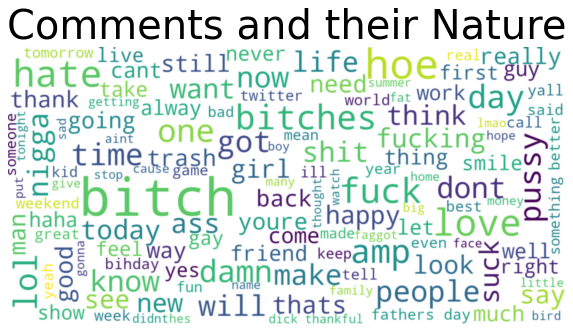

In [21]:
from wordcloud import WordCloud
words = ' '.join([text for text in train_df['tweet']])


word_cloud = WordCloud(width=1600,
                       height=800,
                       margin=0,
                       max_words=500, # Maximum numbers of words we want to see 
                       min_word_length=3, # Minimum numbers of letters of each word to be part of the cloud
                       max_font_size=150, min_font_size=30,  # Font size range
                       background_color="white").generate(words)

plt.figure(figsize=(10, 16))
plt.imshow(word_cloud, interpolation="gaussian")
plt.title('Comments and their Nature', fontsize = 40)
plt.axis("off")
plt.show()

In [23]:

x=train_df['tweet']
y=train_df["label"]

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [25]:
print(x_train.shape)
print(y_train.shape)

(61351,)
(61351,)


In [26]:
x_train.head()

385             im waiting for a follow since the x factor
69736    that sucks jon hope hes well in time for chris...
64364                                          gypsy bitch
27272            a as auld chalkboard architecture please 
7359     now this is very funny politics is not everyth...
Name: tweet, dtype: object

In [27]:
y_train.head()

385      0
69736    0
64364    1
27272    0
7359     0
Name: label, dtype: int64

In [28]:
max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)


In [29]:
list_tokenized_train[:1]

[[23, 463, 13, 3, 274, 400, 1, 611, 5289]]

In [30]:
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # train
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) # test 

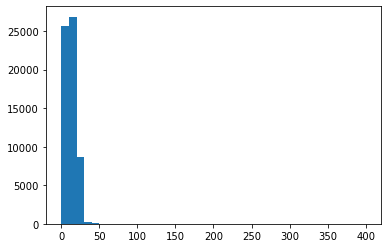

In [31]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [32]:
import os
embeddings_index = {}
embedding_dim = 100

GLOVE_DIR = "D:\glove.twitter.27B"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [33]:

word_index = tokenizer.word_index # and this tokenizer is trained/fit on training data
max_words = len(word_index)
embedding_dim = 100 # dimension of output of embedding layer to be, its 100 as we are using pre trained with 100
embedding_matrix = np.zeros((max_words + 1, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [34]:
from tensorflow.python.keras.utils import layer_utils
# embed_size = 128
# maxlen = 200
# max_features = 22000

# inp = Input(shape = (maxlen, ))
# x = Embedding(max_features, embed_size)(inp)

embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)